In [42]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import xml.etree.ElementTree as et
import os
import cv2
from matplotlib import pyplot as plt
import random


In [19]:
def is_monotonic(mat): 
    return (all(mat[i] <= mat[i + 1] for i in range(len(mat) - 1)) or
            all(mat[i] >= mat[i + 1] for i in range(len(mat) - 1)))

def coor_area(box):
    coor_diff = [x1 - x2 for (x1, x2) in zip(box[0], box[1])]
    return abs(coor_diff[0] * coor_diff[1])

In [20]:
def iou_cal(box1, box2):
    transpose = lambda x: list(map(list, zip(*x)))
    box1_t, box2_t = transpose(box1), transpose(box2)
    x_array = box1_t[0] + box2_t[0]
    y_array = box1_t[1] + box2_t[1]
    if (is_monotonic(x_array) or is_monotonic(y_array)):
        return None
    else:
        x_array.sort()
        y_array.sort()
        overlap = abs((x_array[2] - x_array[1]) * (y_array[2] - y_array[1]))
        return  overlap / (coor_area(box1) + coor_area(box2) - overlap)

In [21]:
def file_parse(file_name):
    boxes = []
    current_path = os.path.abspath("./HW2_Data/Annotations/")
    xml_path = os.path.join(current_path, file_name+'.xml')
    tree = et.parse(xml_path)
    root = tree.getroot()
    for objects in root.findall('object'):
        for box in objects.findall('bndbox'):
            boxes.append([[int(box.find('xmin').text), int(box.find('ymin').text)], 
                         [int(box.find('xmax').text), int(box.find('ymax').text)]])
    
    current_path = os.path.abspath("./HW2_Data/JPEGImages/")
    jpg_path = os.path.join(current_path, file_name+'.jpg')
    img = cv2.imread(jpg_path)
    return boxes, img

In [22]:
a = [[2,2],[4,5]]
b = [[1.5,2],[6,3]]
print(iou_cal(a,b))

0.23529411764705882


In [23]:
file_list = {'000009', '000220', '002129', '006919'}
for file_name in file_list:
    box_list, img = file_parse(file_name)
    
    

TypeError: must be real number, not builtin_function_or_method

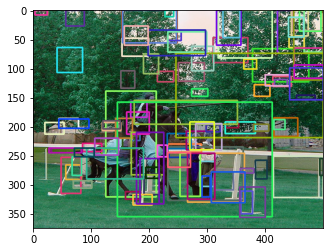

In [50]:
box_list, img = file_parse('000009')
ss_c = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategyColor()
ss_t = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategyTexture()
ss_m = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategyMultiple()
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.addStrategy(ss_c)
ss.setBaseImage(img)
ss.switchToSelectiveSearchQuality()
boxes = ss.process()

for i, rect in enumerate(boxes):
    if i < 100:
        x, y, w, h = rect
        color = random.sample(range(0, 255), 3)
        cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
    else: break
        
plt.imshow(img)
plt.show()